# Setup

In [4]:
import sys
sys.path.insert(0, '/home/563/esh563/TINT')
sys.path.insert(0, '/home/563/esh563/pyart')

In [5]:
# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
import tint.visualization
import tint.visualization_aux
from tint import animate


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/563/esh563/pyart/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/563/esh563/pyart/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [6]:
import CPOL_func as cf
import caine_func as caf
import helpers

In [7]:
# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport tint.visualization
%aimport tint.visualization_aux
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport helpers

In [8]:
%pdb

Automatic pdb calling has been turned ON


# Create Tracks

In [9]:
mp='lin'

In [10]:
filenames = cf.CPOL_files_from_datetime_list(
        np.arange(np.datetime64('2003-01-01 10:00'), 
                  np.datetime64('2003-01-01 12:00'), 
                  np.timedelta64(10, 'm')))[0]

Gathering files.


In [21]:
filenames = caf.caine_files_from_datetime_list(
    np.arange(
        np.datetime64('2006-02-11 00:00'), 
        np.datetime64('2006-02-11 02:00'), 
        np.timedelta64(10, 'm')), mp='lin')[0]

Gathering files.


In [22]:
filenames

['/g/data/w40/esh563/lind04_ref/lind04_ref_2006-02-11T00:00:00.nc',
 '/g/data/w40/esh563/lind04_ref/lind04_ref_2006-02-11T00:10:00.nc',
 '/g/data/w40/esh563/lind04_ref/lind04_ref_2006-02-11T00:20:00.nc',
 '/g/data/w40/esh563/lind04_ref/lind04_ref_2006-02-11T00:30:00.nc',
 '/g/data/w40/esh563/lind04_ref/lind04_ref_2006-02-11T00:40:00.nc',
 '/g/data/w40/esh563/lind04_ref/lind04_ref_2006-02-11T00:50:00.nc',
 '/g/data/w40/esh563/lind04_ref/lind04_ref_2006-02-11T01:00:00.nc',
 '/g/data/w40/esh563/lind04_ref/lind04_ref_2006-02-11T01:10:00.nc',
 '/g/data/w40/esh563/lind04_ref/lind04_ref_2006-02-11T01:20:00.nc',
 '/g/data/w40/esh563/lind04_ref/lind04_ref_2006-02-11T01:30:00.nc',
 '/g/data/w40/esh563/lind04_ref/lind04_ref_2006-02-11T01:40:00.nc',
 '/g/data/w40/esh563/lind04_ref/lind04_ref_2006-02-11T01:50:00.nc']

In [23]:
def gen_tracks(filenames, rain=False):

    # Get grid generator 
    # Note generators produce iterators
    # These are essentially alternative to using lists and looping
    grids = (
        pyart.io.read_grid(
            fn, include_fields = [
                'reflectivity'])
            for fn in filenames)

    b_path = '/g/data/w40/esh563/CPOL_analysis/TINT_tracks/circ_b_ind_set.pkl' 
    with open(b_path, 'rb') as f:
        b_ind_set = pickle.load(f)

    # Define settings for tracking
    settings = {
        'MIN_SIZE' : [40, 400, 800], # square km
        'FIELD_THRESH' : ['convective', 20, 15], # DbZ
        'ISO_THRESH' : [10, 10, 10], # DbZ
        'GS_ALT' : 3000,
        'SEARCH_MARGIN' : 50000, # m. This is just for object matching step:
        # does not affect flow vectors. Note CPOL cells 2500mx2500m. 
        'FLOW_MARGIN' : 40000, # m. Margin around object over which to
        # perform phase correlation.
        'LEVELS' : np.array( # m
            [[3000, 3500], [3500, 7500], [7500, 10000]]),
        'TRACK_INTERVAL' : 0,
        'BOUNDARY_GRID_CELLS' : b_ind_set,
        'UPDRAFT_START': 3000}

    tracks_obj  = tint.Cell_tracks()
    parameters = [
        'MIN_SIZE', 'FIELD_THRESH', 'GS_ALT', 'LEVELS', 'TRACK_INTERVAL', 
        'ISO_THRESH', 'SEARCH_MARGIN', 'FLOW_MARGIN', 'BOUNDARY_GRID_CELLS', 
        'UPDRAFT_START']
    for parameter in parameters:
        tracks_obj.params[parameter] = settings[parameter]

    # Create directory for figures
    dt=str(datetime.datetime.now())[0:-7]
    dt=dt.replace(" ", "_")
    dt=dt.replace(":", "_")
    dt=dt.replace("-", "")
        
    # Calculate tracks
#     %lprun -T lprof0 -f tint.tracks.Cell_tracks.get_tracks tracks_obj.get_tracks(grids)
    tracks_obj.get_tracks(grids, dt=dt, rain=rain)
    #tracks_obj = helpers.get_reanalysis_vars(tracks_obj)
    #tracks_obj = helpers.add_monsoon_regime(tracks_obj)
 
    out_file_name = ('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/'
                     + 'tracks_obj_{}_{}.pkl'.format(mp,dt))

    with open(out_file_name, 'wb') as f:
        pickle.dump(tracks_obj, f)
        
    return tracks_obj

In [26]:
tracks_obj = gen_tracks(filenames)

IndexError: list index out of range

> /home/563/esh563/TINT/tint/objects.py(400)get_object_prop()
    398 
    399             # Append list of objects that have merged with obj
--> 400             mergers.append(current_objects['mergers'][obj-1])
    401             # Append parent(s) of obj
    402             parent.append(current_objects['parents'][obj-1])

ipdb> u
> /home/563/esh563/TINT/tint/tracks.py(290)get_tracks()
    288                     self.record.interval.total_seconds(), rain, save_rain)
    289             obj_merge = obj_merge_new
--> 290             obj_props = get_object_prop(
    291                 frames1, cores1, grid_obj1, u_shift, v_shift, sclasses1,
    292                 self.field, self.record, self.params, self.current_objects, rain)

ipdb> l
    285                     frames1, frames2,
    286                     acc_rain_list, acc_rain_uid_list,
    287                     pairs, self.current_objects, self.counter, obj_merge,
    288                     self.record.interval.total_secon

In [6]:
tracks_obj = helpers.add_monsoon_regime(tracks_obj)

# Load Tracks

In [5]:
with open('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/tracks_obj_2001_2002.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)

# Create Animations

In [15]:
def test():
    lon_min = 131.0 - 1.6
    lon_max = 131.0 + 1.6

    lat_max = -12.2 + 1.6
    lat_min = -12.2 - 1.6
    
    tracks_obj_temp = tracks_obj

#     filenames, start_time, end_time = caf.caine_files_from_TINT_obj(
#         tracks_obj_temp, '13', mp=mp
#     )
    
    [filenames, start_time, end_time] = cf.CPOL_files_from_datetime_list(
        np.arange(np.datetime64('2003-01-12 14:00'), 
                  np.datetime64('2003-01-12 16:40'), 
                  np.timedelta64(10, 'm'))
    )

#     [filenames, start_time, end_time] = caf.caine_files_from_datetime_list(
#         np.arange(np.datetime64('2006-02-09 10:00'), 
#                   np.datetime64('2006-02-09 11:00'), 
#                   np.timedelta64(10, 'm')), mp='lin'
#     )
    
#     tracks_obj_temp.tracks = tracks_obj_temp.tracks[sub_cond]
#     tracks_obj_temp.system_tracks = tracks_obj_temp.system_tracks[sub_cond_sys]

    # Generate grid generator 
    # Note generators produce iterators
    # These are alternative to using lists and looping
    grids = (pyart.io.read_grid(fn, include_fields = 'reflectivity')
             for fn in filenames)

    # Create directory for figures
    dt=str(datetime.datetime.now())[0:-7]
    dt=dt.replace(" ", "_")
    dt=dt.replace(":", "_")
    dt=dt.replace("-", "")

    base_path = '/g/data/w40/esh563/CPOL_analysis/figures/TINT/'
    out_path = base_path + dt + '_tint_CPOL_anim'

    animate(tracks_obj_temp, grids, out_path,
            start_datetime = start_time,
            end_datetime = end_time,
            lat_lines=np.arange(lat_min, lat_max, .2),
            lon_lines=np.arange(lon_min, lon_max, .2),
            tracers=False, keep_frames=False, dpi=100, alt_low=3000,
            alt_high=10000, scan_boundary=False, wrf_winds=False, 
            line_coords=False, mp=mp, rain=False)
    
if __name__ == '__main__':
    try:
        test()
    except:
        extype, value, tb = sys.exc_info()
        traceback.print_exc()
        pdb.post_mortem(tb)

Gathering files.
Animating from 2003-01-12T14:00 to 2003-01-12T16:30.
Plotting scan at 2003-01-12T16:20:01.
Reached 2003-01-12T16:30.
Breaking loop.

Creating GIF - may take a few minutes.


In [ ]:
def test():
    uid = '13'
    filenames, start_time, end_time = caf.caine_files_from_TINT_obj(
        tracks_obj, uid, mp=mp    
    )

    lon_min = 131.0 - 2.6
    lon_max = 131.0 + 2.6

    lat_max = -12.2 + 2.6
    lat_min = -12.2 - 2.6
    
#     [filenames, start_time, end_time] = cf.CPOL_files_from_datetime_list(
#         np.arange(np.datetime64('2003-12-20 08:20'), 
#                   np.datetime64('2003-12-20 08:30'), 
#                   np.timedelta64(10, 'm'))
#     )

#     [filenames, start_time, end_time] = caf.caine_files_from_datetime_list(
#         np.arange(np.datetime64('2006-02-09 10:30'), 
#                   np.datetime64('2006-02-09 10:40'), 
#                   np.timedelta64(10, 'm')), mp=mp
#     )

    grids = (pyart.io.read_grid(fn) for fn in filenames)  
    # refresh grid generator

    # Create directory for figures
    dt=str(datetime.datetime.now())[0:-7]
    dt=dt.replace(" ", "_")
    dt=dt.replace(":", "_")
    dt=dt.replace("-", "")
    
    base_path = '/g/data/w40/esh563/CPOL_analysis/figures/TINT/'
    out_path = base_path + dt + '_tint_CPOL_lagrangian'
    animate(tracks_obj, grids, out_path, style='updraft', uid=uid, 
            alt_low=3000, alt_high=10000, keep_frames=False, dpi=100,
            lat_lines=np.arange(lat_min, lat_max, .2),
            lon_lines=np.arange(lon_min, lon_max, .2), 
            center_ud=False, wrf_winds=True, line_coords=True,
            average_along_line=True, quiver=False, mp=mp)
    
if __name__ == '__main__':
    try:
        test()
    except:
        extype, value, tb = sys.exc_info()
        traceback.print_exc()
        pdb.post_mortem(tb)

# Create Categories

In [7]:
categories = helpers.create_categories(tracks_obj)

In [8]:
subset_logic = (categories['not_border'] & categories['not_border_0'] 
                & ~categories['large_area'] & ~categories['small_area'] 
                & categories['linear'] & ~categories['stationary'] 
                & categories['sig_vel_mag'])
sub_cat = categories[subset_logic]

In [9]:
uids = list(set([tracks_obj.system_tracks.index[i][2] for i in range(len(tracks_obj.system_tracks))]))

ratio = []
tot_rain = []

for u in uids:
    hours = len(tracks_obj.system_tracks.xs(u, level='uid'))*1/6
    r = categories.xs(u, level='uid')['par_align'].sum()/len(tracks_obj.system_tracks.xs(u, level='uid'))
    ratio.append(r)
    tot_rain.append(tracks_obj.system_tracks.xs(u, level='uid')['tot_rain'][-1])
# tracks_obj.system_tracks.xs('0', level='uid')['vel_dir']

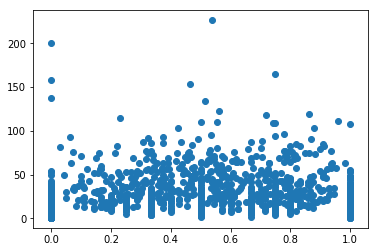

In [10]:
tot_rain = np.array(tot_rain)
tot_rain[tot_rain>500]=np.nan
plt.scatter(ratio, tot_rain)

In [73]:
sub_cat['par_align'].groupby(level='uid').sum().sort_values(ascending=False)[:20]

Series([], Name: par_align, dtype: bool)

# Calculate Some Statistics

## PS, TS, LS Breakdown

In [34]:
subset_logic = sig_area & not_border & not_border_0 & sig_vel_mag & sig_tilt_mag
sub_tracks = tracks_obj.system_tracks[subset_logic]
# sub_tracks = tracks_obj.system_tracks

sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2]) for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]
max_MCS = max(MCS_lengths)

# Create 3 lists with lengths the lifetime of longest object.
[TS, LS, PS, totals] = [np.zeros(100) for i in range(4)]

for i in sub_uids:
    
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    tilts = obj['sys_rel_tilt_dir']
    
    # Break down sig_tilt categories
    forward_tilt = ((-45 <= tilts) & (tilts <= 45)) 
    backward_tilt = ((-135 >= tilts) | (tilts >= 135)) 

    fwd_inds = scan_label[np.argwhere(forward_tilt).flatten().tolist()].tolist()
    bwd_inds = scan_label[np.argwhere(backward_tilt).flatten().tolist()].tolist()
    pll_inds = scan_label[np.argwhere(~backward_tilt & ~forward_tilt).flatten().tolist()].tolist()
    totals_inds = scan_label.tolist()

    # Found error with large com dataset - object 14060 jumps across seasons
    try:
        TS[bwd_inds] += 1
        LS[fwd_inds] += 1
        PS[pll_inds] += 1
        totals[totals_inds] += 1
    except:
        print('Error with system {}.'.format(i))

## System Size

In [7]:
# subset_logic = ~small_area
# sub_tracks = tracks_obj.system_tracks[subset_logic]
sub_tracks = tracks_obj.system_tracks

sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2]) for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

# MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]
# max_MCS = max(MCS_lengths)

In [14]:
# Create 3 lists with lengths the lifetime of longest object.
[large, small, medium, nb, totals] = [np.zeros(100) for i in range(5)]

from tqdm import tqdm

for i in tqdm(sub_uids, file=sys.stdout, position=0, leave=True):
    
#     import pdb
#     pdb.set_trace()
    
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    cat = categories.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    
    # Define classifications
    large_area = cat['large_area'].values
    small_area = cat['small_area'].values
    medium_area = ~large_area & ~small_area
    not_border = cat['not_border'].values | cat['not_border_0'].values
    
    large_inds = scan_label[large_area]
    medium_inds = scan_label[medium_area]
    small_inds = scan_label[small_area]
    not_border_inds = scan_label[not_border]
    totals_inds = scan_label.tolist()
    
    # Break down sig_tilt categories
#     forward_tilt = ((-45 <= tilts) & (tilts <= 45)) 
#     backward_tilt = ((-135 >= tilts) | (tilts >= 135)) 

#     fwd_inds = scan_label[np.argwhere(forward_tilt).flatten().tolist()].tolist()
#     bwd_inds = scan_label[np.argwhere(backward_tilt).flatten().tolist()].tolist()
#     pll_inds = scan_label[np.argwhere(~backward_tilt & ~forward_tilt).flatten().tolist()].tolist()

    # Found error with large com dataset - object 14060 jumps across seasons
    try:
        large[large_inds] += 1
        small[small_inds] += 1
        medium[medium_inds] += 1
        nb[not_border_inds] += 1
        totals[totals_inds] += 1
    except:
        print('Error with system {}.'.format(i))

100%|██████████| 25948/25948 [02:18<00:00, 186.83it/s]


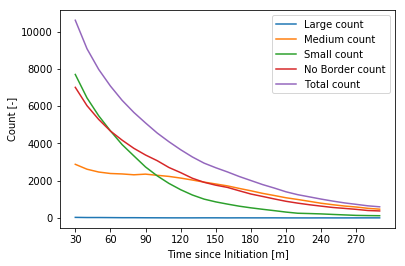

In [17]:
plt.plot(np.arange(30,300,10), large[3:30], label='Large count')
plt.plot(np.arange(30,300,10), medium[3:30], label='Medium count')
plt.plot(np.arange(30,300,10), small[3:30], label='Small count')
plt.plot(np.arange(30,300,10), nb[3:30], label='No Border count')
plt.plot(np.arange(30,300,10), totals[3:30], label='Total count')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_counts.png')

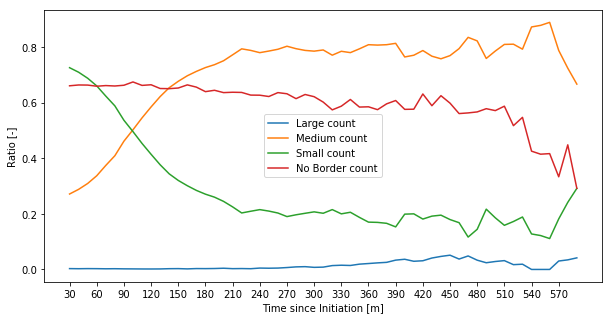

In [22]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(30,600,10), (large/totals)[3:60], label='Large count')
plt.plot(np.arange(30,600,10), (medium/totals)[3:60], label='Medium count')
plt.plot(np.arange(30,600,10), (small/totals)[3:60], label='Small count')
plt.plot(np.arange(30,600,10), (nb/totals)[3:60], label='No Border count')
plt.xticks(np.arange(30,600,30))
plt.ylabel('Ratio [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
# Note that we don't really know the start times of the systems!
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_ratios.png')

## Training Lines

In [12]:
subset_logic = (categories['not_border'] & categories['not_border_0']
                & ~categories['large_area'] & ~categories['small_area'] 
                & categories['linear'] & ~categories['stationary']
                & categories['sig_vel_mag'])
sub_tracks = tracks_obj.system_tracks[subset_logic]
sub_cat = categories[subset_logic]
# sub_tracks = tracks_obj.system_tracks
# sub_cat = categories

sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2])
                            for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

# MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]
# max_MCS = max(MCS_lengths)

In [13]:
# Create 3 lists with lengths the lifetime of longest object.
[par, perp, totals] = [np.zeros(100) for i in range(3)]

from tqdm import tqdm

for i in tqdm(sub_uids, file=sys.stdout, position=0, leave=True):
       
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    cat = sub_cat.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    
    # Define classifications
    perp_align = cat['perp_align'].values
    par_align = cat['par_align'].values
        
    par_inds = scan_label[par_align]
    perp_inds = scan_label[perp_align]
    totals_inds = scan_label.tolist()

    # Found error with large com dataset - object 14060 jumps across seasons
    try:
        par[par_inds] += 1
        perp[perp_inds] += 1
        totals[totals_inds] += 1
    except:
        print('Error with system {}.'.format(i))

100%|██████████| 91/91 [00:00<00:00, 170.20it/s]


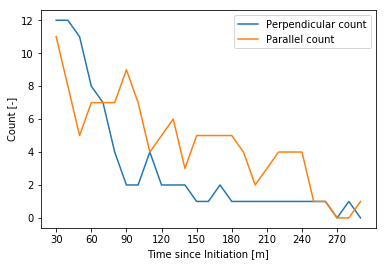

In [14]:
plt.plot(np.arange(30,300,10), perp[3:30], label='Perpendicular count')
plt.plot(np.arange(30,300,10), par[3:30], label='Parallel count')
# plt.plot(np.arange(30,300,10), totals[3:30], label='Total count')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_counts.png')

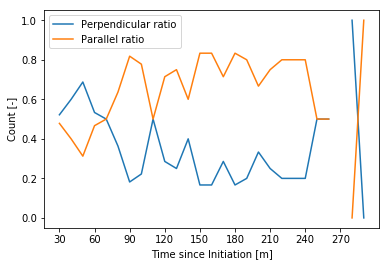

In [15]:
plt.plot(np.arange(30,300,10), (perp/totals)[3:30], label='Perpendicular ratio')
plt.plot(np.arange(30,300,10), (par/totals)[3:30], label='Parallel ratio')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_counts.png')

## Updraft Tilt versus Stratiform Tilt

In [29]:
def calc_mean_max_updrafts(system_tracks, min_height_ind = 20):
    ud = system_tracks['updrafts']
    ud_tilt = []
    tallest_ud = []
    mean_ud = []
    no_tilt=0
    for i in range(len(ud)):
        ud_i = ud.iloc[i]
        ud_tilt_i = []
        for j in range(len(ud_i)):
            if ud_i[j][-1][0] >= min_height_ind:
                ud_tilt_i_j = (ud_i[j][-1]-ud_i[j][0])*(.5, 2.5, 2.5)
                if np.all(ud_tilt_i_j[1:3] == [0,0]):
                    # Count updrafts with no tilt seperately
                    no_tilt+=1
                else:
                    ud_tilt_i.append(ud_tilt_i_j)
       
        if ud_tilt_i != []:
            ud_tilt.append(ud_tilt_i)
            mean_ud.append(np.nanmean(np.array(ud_tilt_i), axis=0))
        else:
            ud_tilt.append(np.ones(3)*np.nan)
            mean_ud.append(np.ones(3)*np.nan)
        try:
            tallest_ind = np.argmax(np.array(ud_tilt_i)[:,0])
            tallest_ud.append(np.array(ud_tilt_i)[tallest_ind,:])
        except:
            tallest_ud.append(np.ones(3)*np.nan)
        
    return ud_tilt, mean_ud, tallest_ud

### Tallest Updraft

In [33]:
subset_logic = sig_area & not_border & sig_tilt_mag & not_border_0 & sig_vel_mag
sub_tracks = tracks_obj.system_tracks[subset_logic]
ud_tilt, mean_ud, tallest_ud = calc_mean_max_updrafts(sub_tracks)

num = np.array(tallest_ud)
den = np.tile(np.array(tallest_ud)[:,0], (3,1)).transpose()
ud_norm = (num/den)[:,1:]
ud_mag = np.sqrt(ud_norm[:,0] ** 2 + ud_norm[:,1] ** 2)
ud_dir = np.arctan2(ud_norm[:,0], ud_norm[:,1])
ud_dir = np.rad2deg(ud_dir)

vel_dir = sub_tracks['vel_dir'].values
tilt_dir = sub_tracks['tilt_dir'].values

sys_rel_tilt_dir = np.mod(tilt_dir - vel_dir, 360)
sys_rel_tilt_dir = np.round(sys_rel_tilt_dir, 3)

sys_rel_ud_tilt_dir = np.mod(ud_dir - vel_dir, 360)
sys_rel_ud_tilt_dir = np.round(sys_rel_ud_tilt_dir, 3)

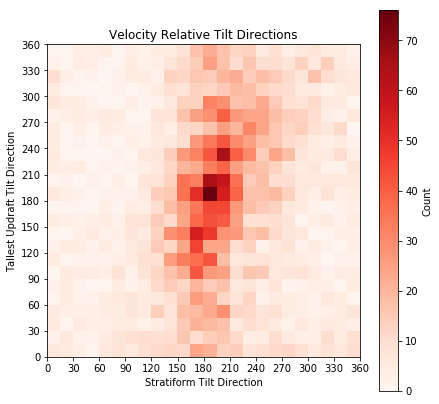

In [35]:
vel_dir = sub_tracks['vel_dir'].values
vel_mag = np.sqrt(sub_tracks['u_shift']**2 + sub_tracks['v_shift']**2).values
tilt_dir = sub_tracks['tilt_dir'].values
bins = np.arange(0,360+15,15)
ticks = np.arange(0,360+30,30)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111)
h = ax.hist2d(sys_rel_tilt_dir, sys_rel_ud_tilt_dir, bins=bins, range=[[0, 360], [0, 360]], cmap='Reds')
# ax.scatter(tilt_dir, ud_dir, s=0.75)
plt.xlabel('Stratiform Tilt Direction')
plt.ylabel('Tallest Updraft Tilt Direction')
plt.title('Velocity Relative Tilt Directions')
plt.xlim([0, 360])
plt.ylim([0, 360])
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_aspect('equal')
cb = plt.colorbar(h[3], ax=ax)
cb.set_label('Count')

### Mean Updraft

In [36]:
subset_logic = sig_area & not_border & sig_tilt_mag & not_border_0 & sig_vel_mag
sub_tracks = tracks_obj.system_tracks[subset_logic]
ud_tilt, mean_ud, tallest_ud = calc_mean_max_updrafts(sub_tracks)

num = np.array(mean_ud)
den = np.tile(np.array(mean_ud)[:,0], (3,1)).transpose()
ud_norm = (num/den)[:,1:]
ud_mag = np.sqrt(ud_norm[:,0] ** 2 + ud_norm[:,1] ** 2)
ud_dir = np.arctan2(ud_norm[:,0], ud_norm[:,1])
ud_dir = np.rad2deg(ud_dir)

vel_dir = sub_tracks['vel_dir'].values
tilt_dir = sub_tracks['tilt_dir'].values

sys_rel_tilt_dir = np.mod(tilt_dir - vel_dir, 360)
sys_rel_tilt_dir = np.round(sys_rel_tilt_dir, 3)

sys_rel_ud_tilt_dir = np.mod(ud_dir - vel_dir, 360)
sys_rel_ud_tilt_dir = np.round(sys_rel_ud_tilt_dir, 3)

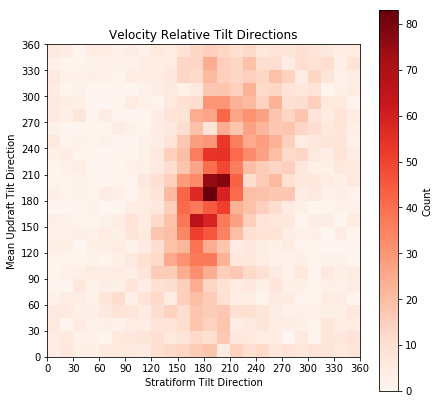

In [38]:
vel_dir = sub_tracks['vel_dir'].values
vel_mag = np.sqrt(sub_tracks['u_shift']**2 + sub_tracks['v_shift']**2).values
tilt_dir = sub_tracks['tilt_dir'].values
bins = np.arange(0,360+15,15)
ticks = np.arange(0,360+30,30)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111)
h = ax.hist2d(sys_rel_tilt_dir, sys_rel_ud_tilt_dir, bins=bins, range=[[0, 360], [0, 360]], cmap='Reds')
# ax.scatter(tilt_dir, ud_dir, s=0.75)
plt.xlabel('Stratiform Tilt Direction')
plt.ylabel('Mean Updraft Tilt Direction')
plt.title('Velocity Relative Tilt Directions')
plt.xlim([0, 360])
plt.ylim([0, 360])
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_aspect('equal')
cb = plt.colorbar(h[3], ax=ax)
cb.set_label('Count')